# Homework #8: Wavelet
|Author| Stanley A. Baronett|
|--|-------------------------------|
|Created | 5/3/2020|

In this notebook, we use the _continuous wavelet transform_ to analyze a "chip signal," similar to the landmark gravitational wave observations made by LIGO in 2015.

## Motivation

Although the Fourier transform is very powerful tool in signal analysis, it's efficacy is often limited to _stationary_ signals. Spectral analysis of _nonstationary_, or time-varying, signals requires slightly different approaches, such as Short-time Fourier Transform (STFT) or _wavelet analysis_. A discussion and application of STFT in the context of music can be found in the Jupyter notebook [here](https://nbviewer.jupyter.org/github/sabaronett/2017-cmp/blob/master/projects/project1/Baronett_project1_1_main.ipynb#Short-time-Fourier-Transform-(STFT)). However, STFT also suffers inherent limitations compared with wavelets.

One issue with STFT falls on its inherent fixed-resolution, time windows. Because of the _Gabor limit_ (related to the "uncertainty principle"), determining the width of the windowing function necessitates a compromise between either better _frequency_ resolution or better _time_ resolution, but never both. This trade-off became one of the motivations for the development of the wavelet transform and _multiresolution analysis_.

## Continous Wavelet Transform
We define a _wavelet transform_ of a time-varying signal $y(t)$ as

\begin{equation}
    Y(s, \tau) \equiv \int_{-\infty}^{+\infty} \psi^*_{s,\tau}(t) y(t) dt,
    \tag{1}
\end{equation}

where $\psi^*_{s,\tau}(t)$ represent time-localized wave packets, or _wavelets_; $\tau$ corresponds to the time portion of the signal decomposition; and the _scale_, $s$, equals the present frequency during that time, i.e.,

\begin{equation}
    \omega = \dfrac{2\pi}{s} \implies s = \dfrac{2\pi}{\omega} \quad \textrm{(scale-frequency relation)}.
    \tag{2}
\end{equation}


We generate a family of wavelet basis functions, or _daughter_ wavelets, $\psi_{s, \tau}(t)$, from a _mother_, or _analyzing_, function of time, $\Psi(t)$, $t \in \mathbb{R}$. A mother wavelet $\Psi$ must satisfy the following requirements:

1. $\Psi(t)$ is real.
2. The average oscillation of $\Psi(t)$ (around zero) is zero, i.e.,

\begin{equation}
    \int_{-\infty}^{+\infty} \Psi(t)dt = 0.
\end{equation}

3. $\Psi(t)$ is localized, i.e., a finite, square-integrable wave packet,

\begin{equation}
    \Psi(\vert t\vert \rightarrow \infty) \rightarrow 0 \quad \textrm{(rapidly)}, \quad \int_{-\infty}^{+\infty} \vert\Psi(t)\vert^2 dt < \infty.
\end{equation}

4. The tranforms of low powers of $t$ vanish, i.e., the first $p$ moments:

\begin{equation}
    \int_{-\infty}^{+\infty} t^0 \Psi(t)dt = \int_{-\infty}^{+\infty} t^1 \Psi(t)dt = \cdots = \int_{-\infty}^{+\infty} t^{p-1} \Psi(t) dt = 0.
\end{equation}


We define these normalized daughter wavelets as

\begin{equation}
    \psi_{s, \tau}(t) \equiv \dfrac{1}{\sqrt{s}}\Psi\left(\dfrac{t-\tau}{s}\right),
    \tag{3}
\end{equation}

where $s$ scales, and $\tau$ translates, the mother wavelet. Substituting Eq. 3 into Eq. 1, we find

\begin{equation}
    \boxed{Y(s, \tau) = \dfrac{1}{\sqrt{s}} \int_{-\infty}^{+\infty} \Psi^*\left(\dfrac{t-\tau}{s}\right) y(t) dt \quad \textrm{(Wavelet Transform)},}
    \tag{4}
\end{equation}

Programmatically, our goal will be to compute a 2D array of unique _convolutions_ (see the integrands of Eqs. 1 and 4) of a dual-range of daughter wavelets, each with a unique combination of discrete $s$ and $\tau$ values, with our chirp signal. Below we define our continuous wavelet transform (CWT) function, `cwt`.

In [76]:
import numpy as np
import matplotlib.pyplot as plt

def cwt(y, mother='morlet', tmax=20., tres=600, smin=0.1, smax=2.0, sres=200):
    """
    Continuous wavelet transform (CWT) of signal `y` with `mother` wavelet for
    the range of `s` and `tau` values.
    
    Parameters
    ----------
    y : function
        Signal function to be analyzed, i.e., transformed.
    mother : string
        Mother wavelet function from which daughter wavelets are generated.
        Default is Morlet wavelet.
    tmax : float
        Maximum time `t`/`tau` values can take (range from 0 to `tmax`).
        Default set to 20.0.
    tres : int
        Number of intervals for the range of `t`/`tau` values; larger values
        correspond to higher temporal resolution.
        Default set to 500.
    smax : float
        Minimum scale `s` values can take. Smaller values correspond to higher
        frequencies.
        Default set to 0.1.
    smax : float
        Maximum scale `s` values can take. Larger values correspond to lower
        frequencies.
        Default set to 3.1.
    sres : int
        Number of intervals for the range of `s` values; larger values
        correspond to higher frequency resolution.
        Default set to 300.
        
    Returns
    ----------
    ys : ndarray
        1D array of discretized signal.
    Y_stau : ndarray
        2D array of transforms, Y(s, tau).
    """
    ts = np.linspace(0., tmax, tres)
    taus = np.linspace(0., tmax, tres)
    dt = tmax/tres
    ss = np.linspace(smin, smax, sres)
    ys = np.zeros(tres)
    Y_stau = np.zeros((sres, tres), complex)
    
    # for all mother wavelets, width (e.g., sigma) is assumed to be unity
    if mother == 'morlet':
        print("CWT: Using Morlet wavelet")
        Psi = lambda t: np.exp(2.*np.pi*t*1j)*np.exp(-t*t/2.)
    elif mother == 'mexicanhat':
        print("CWT: Using Mexican hat wavelet")
        Psi = lambda t: (1-t*t)*np.exp(-t*t/2.)
        
    # discretize signal
    for i,t in enumerate(ts):
        ys[i] = y(t)
        
    # main wavelet transform, nested loops
    for i,s in enumerate(ss):
        for j,tau in enumerate(taus):
            Y_stau[i,j] = sum(np.conj(Psi((ts - tau)/s))*ys*dt)/np.sqrt(s)
    
    return ts, ys, Y_stau

## Application

Assume the following chirp signal:

\begin{equation}
    y(t) =
    \begin{cases}
        \sin t^2, \quad 0<t<15\\
        0, \hspace{12mm} \textrm{else}\\
    \end{cases}
    \tag{5}
\end{equation}

We now define a Python function for this signal that will later be passed as a parameter to our `cwt` function.

Please do wavelet transform to show the chirp signal is similar to the one you have seen
online. (Notice that the figure online has time as x-axis and frequency as the y-axis)
(You are welcome to use any wavelet you prefer.)

In [114]:
# define our time-varying chirp signal
def chirp(t):
    if (0 <= t and t <= 15):
        return np.sin(t*t)
    else:
        return 0.

In [115]:
times, signal, spectrum = cwt(chirp)

CWT: Using Morlet wavelet


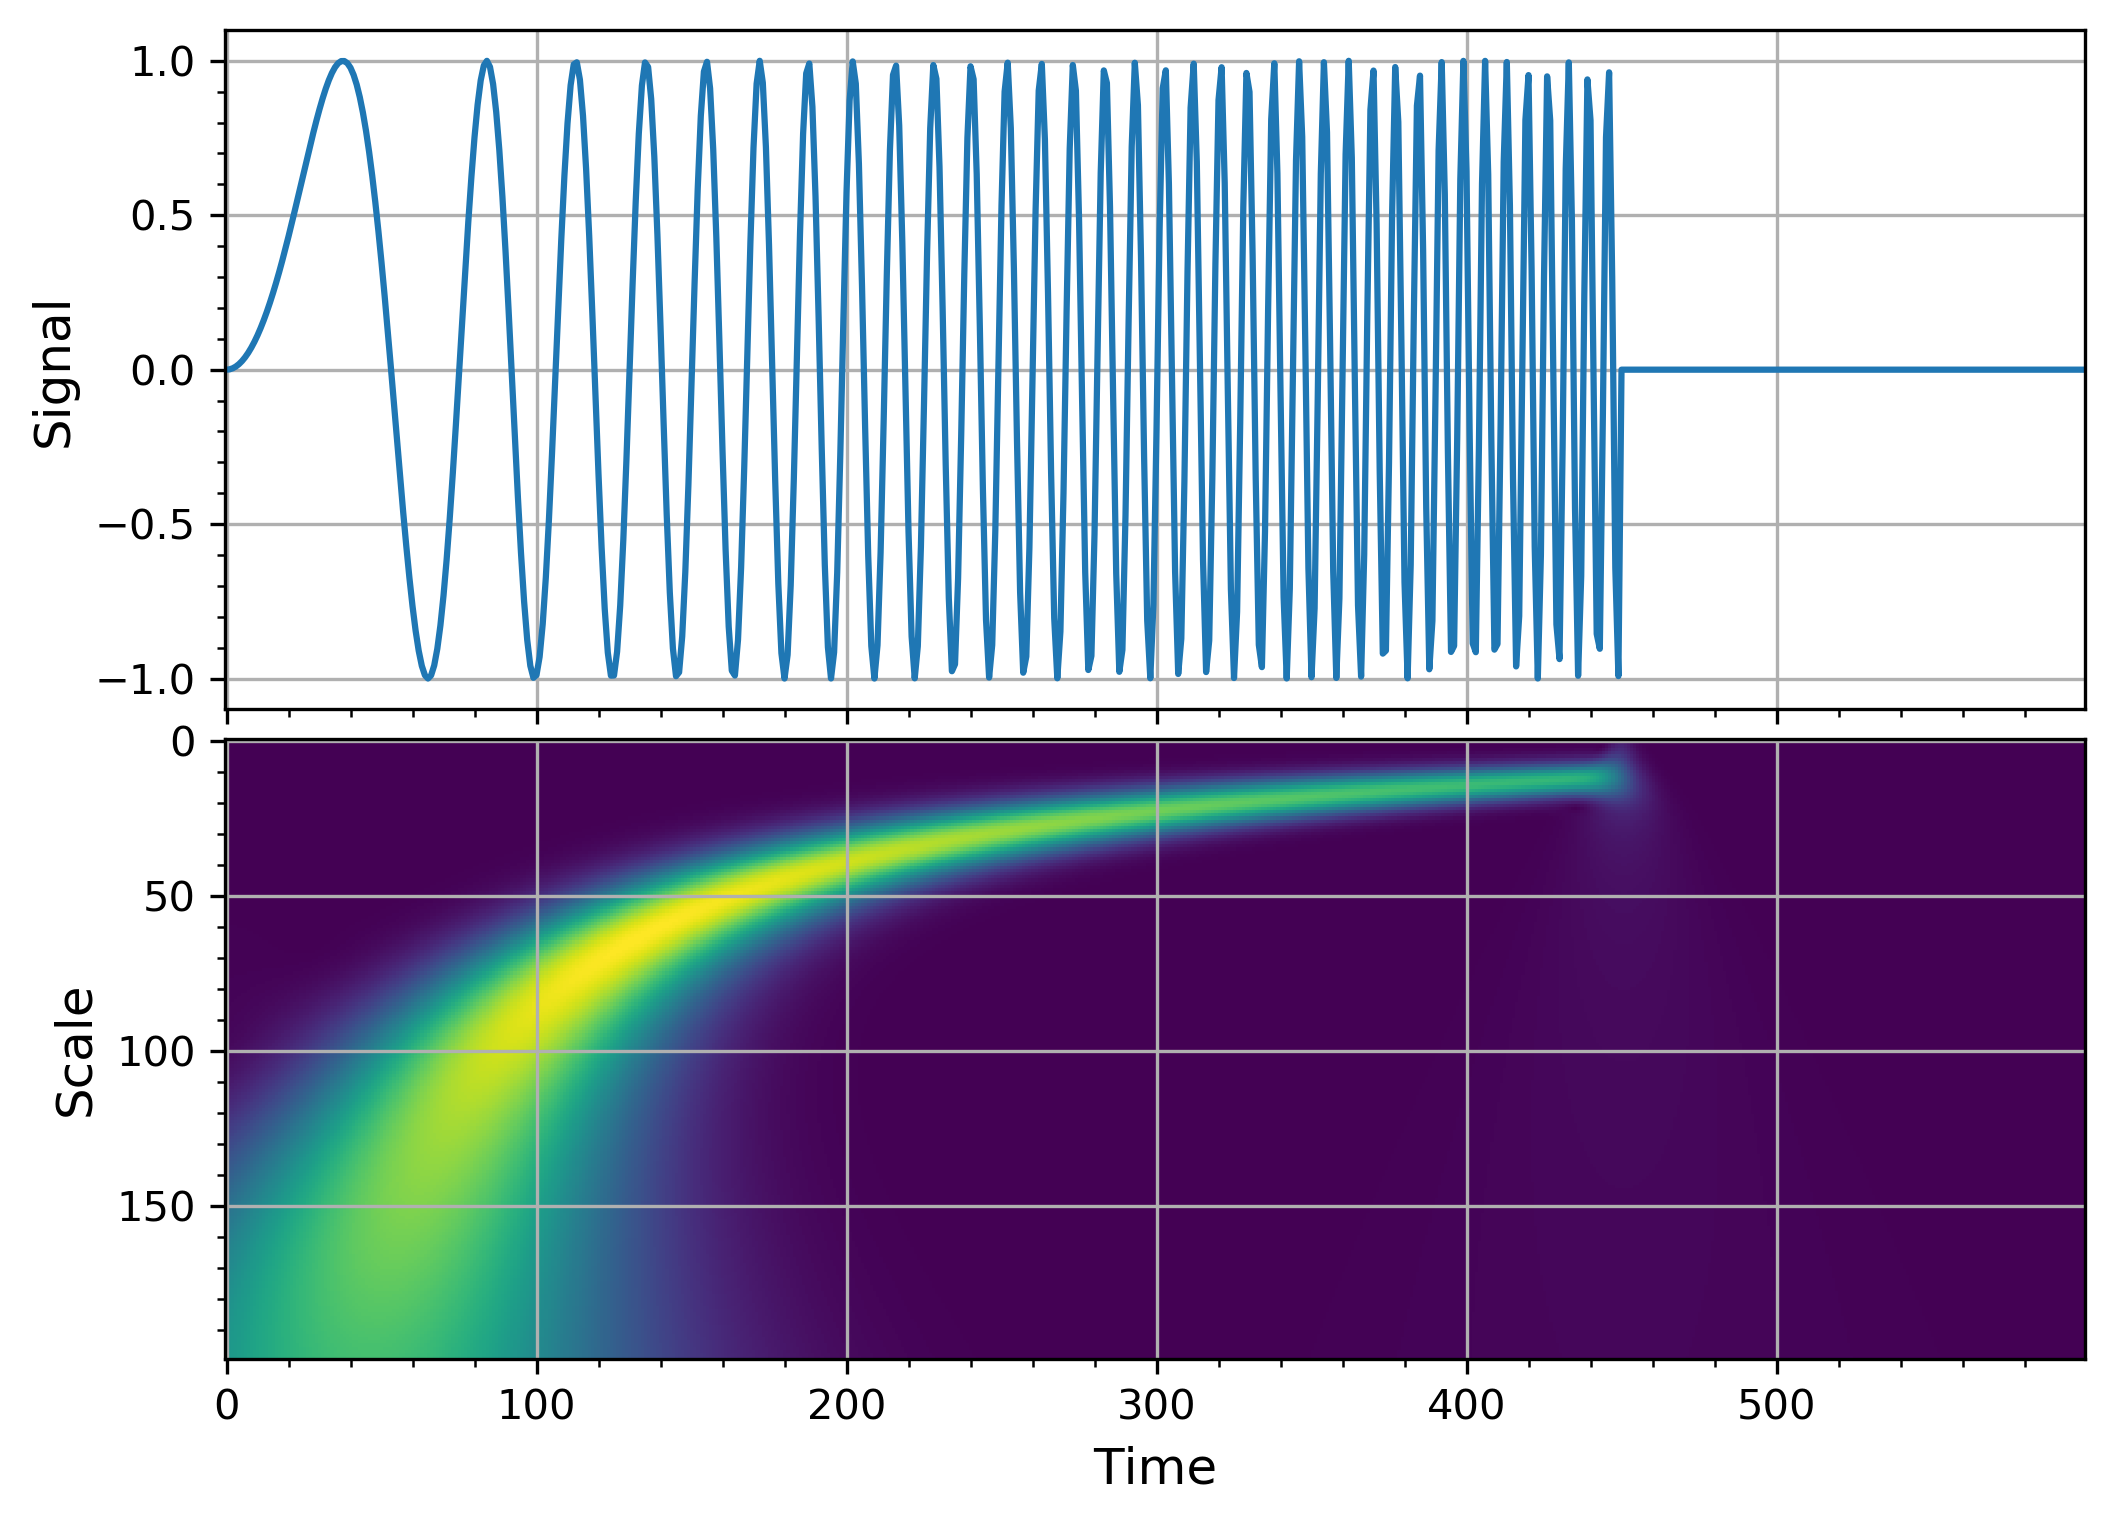

In [116]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 6), dpi=300)
fig.subplots_adjust(hspace=0)

ax1.set_ylabel('Signal', fontsize='large')
ax1.yaxis.set_minor_locator(mticker.AutoMinorLocator())
ax1.plot(signal)
ax1.grid()

ax2.set_xlabel('Time', fontsize='large')
ax2.xaxis.set_minor_locator(mticker.AutoMinorLocator())
ax2.set_ylabel('Scale', fontsize='large')
ax2.yaxis.set_minor_locator(mticker.AutoMinorLocator())
ax2.imshow(np.abs(spectrum), cmap='viridis')
ax2.grid()

Note: the axes labels on the lower spectrogram correspond to indices along the 2D array, i.e., `tres` and `sres`. Recall that lower "scale" values of $s$ correspond to higher frequencies.

For comparison, below is the gravitational wave results from LIGO Hanford:

### LIGO Hanford

![LIGO Hanford](ligo_hanford.png)